# Draw the Mandelbrot Set in Python

$~$

Original Author: [Bartosz Zaczyński](https://realpython.com/mandelbrot-set-python/)

Modifier: Kee-Youn Yoo

In [1]:
%load_ext autoreload
%autoreload 2

## The Boundary of Iterative Stability

>$\begin{align*}
 z_0 &= 0\\ 
 z_{n+1} &= z_n^2 + c 
\end{align*}$

* Formally, $~$the <font color='red'> Mandelbrot set</font> is the set of complex numbers, $\color{red}{c}$, for which an infinite sequence of numbers, $z_0$, $z_1$, $\cdots$, $z_n$, $\cdots$, remains bounded

* The entire Mandelbrot set fits in a circle with a radius of two when depicted on the complex plane. This is a handy fact that’ll let you skip many unnecessary calculations for points that certainly don’t belong to the set

In [2]:
def sequence(c):
    z = 0
    while True:
        yield z
        z = z**2 + c

In [3]:
for n, z in enumerate(sequence(c=1)):
    print(f'z({n}) = {z}')
    if n >= 9:
        break

z(0) = 0
z(1) = 1
z(2) = 2
z(3) = 5
z(4) = 26
z(5) = 677
z(6) = 458330
z(7) = 210066388901
z(8) = 44127887745906175987802
z(9) = 1947270476915296449559703445493848930452791205


* Most numbers will make this sequence diverge to infinity. $~$However, $~$some will keep it **stable** by either converging the sequence to a single value or staying within a bounded range. Others will make the sequence **periodically stable** by cycling back and forth between the same few values. <font color='blue'>Stable and periodically stable values make up the Mandelbrot set</font>

In [4]:
for n, z in enumerate(sequence(c=0)):
    print(f'z({n}) = {z}')
    if n >= 9:
        break

z(0) = 0
z(1) = 0
z(2) = 0
z(3) = 0
z(4) = 0
z(5) = 0
z(6) = 0
z(7) = 0
z(8) = 0
z(9) = 0


In [5]:
for n, z in enumerate(sequence(c=-1)):
    print(f'z({n}) = {z}')
    if n >= 9:
        break

z(0) = 0
z(1) = -1
z(2) = 0
z(3) = -1
z(4) = 0
z(5) = -1
z(6) = 0
z(7) = -1
z(8) = 0
z(9) = -1


* It’s not obvious which numbers are stable and which aren’t, $~$because the formula is sensitive to even the smallest change of the tested value, $c$

* The <font color='red'>fractal</font> corresponding to the Mandelbrot set has a finite area estimated at `1.506484` square units. Mathematicians haven’t pinpointed the exact number yet and don’t know whether it’s rational or not. On the other hand, the perimeter of the Mandelbrot set is infinite

## Plotting the Mandelbrot Set Using Python’s Matplotlib

* To generate the initial set of candidate values, $~$you can take advantage of `np.linspace()`, $~$which creates evenly spaced numbers in a given range:

In [6]:
import numpy as np
np.warnings.filterwarnings('ignore')

def complex_matrix(xmin, xmax, ymin, ymax, pixel_density):
    
    re = np.linspace(xmin, xmax, int((xmax - xmin) * pixel_density))
    im = np.linspace(ymin, ymax, int((ymax - ymin) * pixel_density))

    return re[np.newaxis, :] + im[:, np.newaxis] * 1j

In [7]:
def is_stable(c, num_iterations):
    z = 0
    for _ in range(num_iterations):
        z = z ** 2 + c
    return abs(z) <= 2

### Low-Resolution Scatter Plot

In [8]:
import matplotlib.pyplot as plt

c = complex_matrix(-2, 0.5, -1.5, 1.5, pixel_density=21)
members = c[is_stable(c, num_iterations=20)]

def plot_low_resolution_scatter():
    plt.figure(figsize=(10, 12))
    plt.scatter(members.real, members.imag, color='black', marker='x', s=1)
    plt.gca().set_aspect('equal')
    plt.axis('off')
    plt.tight_layout()

    plt.show()

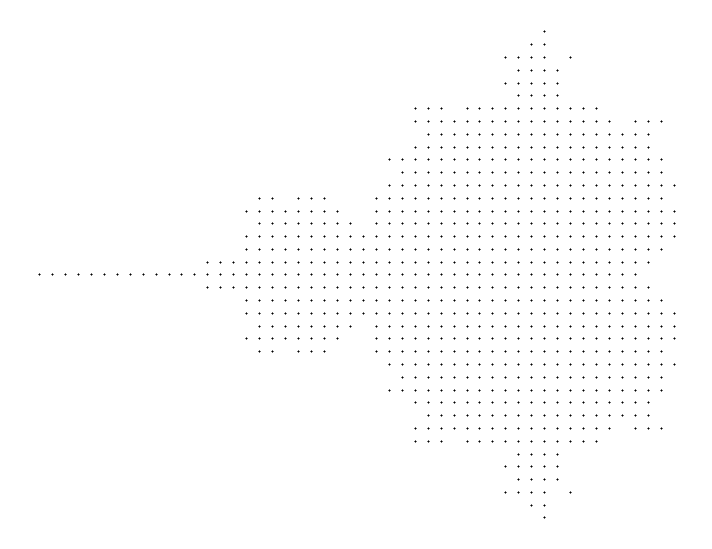

In [9]:
plot_low_resolution_scatter()

### High-Resolution Black-and-White Visualization

In [10]:
c = complex_matrix(-2, 0.5, -1.5, 1.5, pixel_density=512)

def plot_high_resolution_black_and_white():
    plt.figure(figsize=(10, 12))
    plt.imshow(is_stable(c, num_iterations=20), cmap='binary')
    plt.gca().set_aspect('equal')
    plt.axis('off')
    plt.tight_layout()

    plt.show()

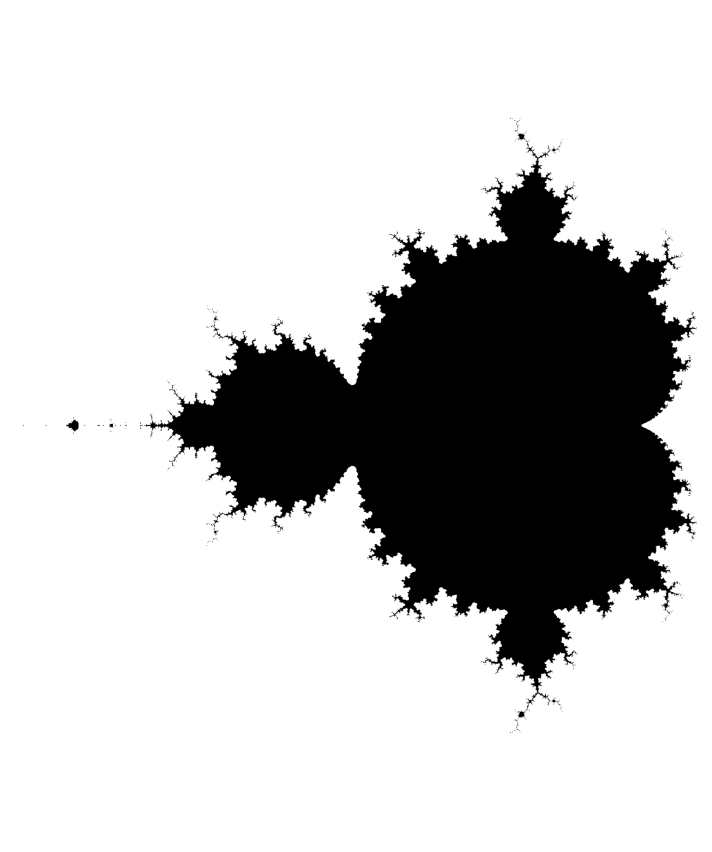

In [11]:
plot_high_resolution_black_and_white()

## Drawing the Mandelbrot Set With Pillow

By replacing Matplotlib’s `plt.imshow()` with a very similar call to Pillow’s factory method:


```python
image = Image.fromarray(~is_stable(c, num_iterations=20))
# image.show()  # for console
display(image)  # for jupyter notebook
```

Notice the use of the bitwise not operator (`~`) in front of your stability matrix, $~$which inverts all of the Boolean values. $~$This is so that the Mandelbrot set appears in black on a white background since Pillow assumes a black background by default

### Finding Convergent Elements of the Set

In [12]:
%%writefile mandelbrot.py

from dataclasses import dataclass

@dataclass
class MandelbrotSet:
    max_iterations: int

    def __contains__(self, c: complex) -> bool:
        z = 0
        for _ in range(self.max_iterations):
            z = z ** 2 + c
            if abs(z) > 2:
                return False     
        return True

Writing mandelbrot.py


In [13]:
from mandelbrot import MandelbrotSet
mandelbrot_set = MandelbrotSet(max_iterations=30)

In [14]:
0.26 in mandelbrot_set

False

In [15]:
0.26 not in mandelbrot_set

True

In [16]:
from mandelbrot import MandelbrotSet
mandelbrot_set = MandelbrotSet(max_iterations=20)

width, height = 512, 512
scale = 0.0055
BLACK_AND_WHITE = '1'

from PIL import Image
image = Image.new(mode=BLACK_AND_WHITE, size=(width, height))

for y in range(height):
    for x in range(width):
        c = scale * complex(x - width / 1.35, height / 2 - y)
        image.putpixel((x, y), c not in mandelbrot_set)

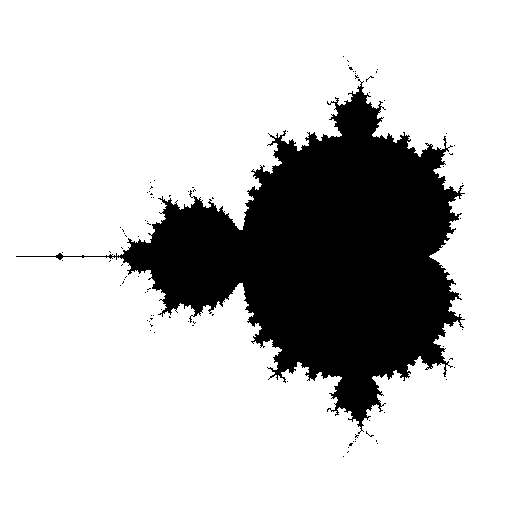

In [17]:
display(image)

### Measuring Divergence With the Escape Count

* The number of iterations it takes to detect divergence is known as the <font color='green'>escape count</font>. $~$We can use the escape count to introduce <font color='green'>multiple levels of gray</font>

* However, $~$it’s usually more convenient to deal with <font color='green'>normalized escape counts</font> so that their values are on a scale from zero to one regardless of the maximum number of iterations

In [18]:
%%writefile mandelbrot.py

from dataclasses import dataclass

@dataclass
class MandelbrotSet:
    max_iterations: int

    def __contains__(self, c: complex) -> bool:
        return self.stability(c) == 1

    def stability(self, c: complex) -> float:
        return self.escape_count(c) / self.max_iterations

    def escape_count(self, c: complex) -> int:
        z = 0
        for iteration in range(self.max_iterations):
            z = z ** 2 + c
            if abs(z) > 2:
                return iteration
        return self.max_iterations

Overwriting mandelbrot.py


In [19]:
from mandelbrot import MandelbrotSet
mandelbrot_set = MandelbrotSet(max_iterations=30)

In [20]:
mandelbrot_set.escape_count(0.25)

30

In [21]:
mandelbrot_set.stability(0.25)

1.0

In [22]:
0.25 in mandelbrot_set

True

In [23]:
mandelbrot_set.escape_count(0.26)

29

In [24]:
mandelbrot_set.stability(0.26)

0.9666666666666667

In [25]:
0.26 in mandelbrot_set

False

* The updated implementation of the `MandelbrotSet` class allows for a grayscale visualization, which ties pixel intensity with stability 

* But you’ll need to change the pixel mode to `L`, $~$which stands for *luminance*. $~$In this mode, $~$each pixel takes an integer value between `0` and `255`, $~$so you’ll also need to scale the fractional stability appropriately:

In [26]:
from mandelbrot import MandelbrotSet
mandelbrot_set = MandelbrotSet(max_iterations=20)

width, height = 512, 512
scale = 0.0055
GRAYSCALE = 'L'

from PIL import Image
image = Image.new(mode=GRAYSCALE, size=(width, height))
for y in range(height):
    for x in range(width):
        c = scale * complex(x - width / 1.35, height / 2 - y)
        instability = 1 - mandelbrot_set.stability(c)
        image.putpixel((x, y), int(instability * 255))

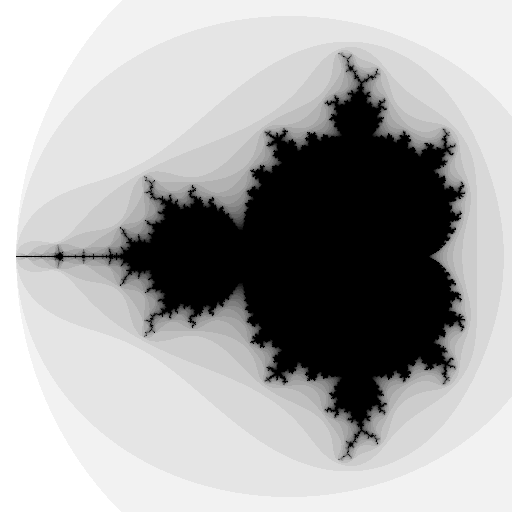

In [27]:
display(image)

### Smoothing Out the Banding Artifacts

* Getting rid of *color banding* from the Mandelbrot set’s exterior boils down to using <font color='green'>fractional escape counts</font>. 

* One way to interpolate their intermediate values is to use [logarithms](https://linas.org/art-gallery/escape/smooth.html)

In [28]:
%%writefile mandelbrot.py

from dataclasses import dataclass
from math import log

@dataclass
class MandelbrotSet:
    max_iterations: int
    escape_radius: float = 2.0

    def __contains__(self, c: complex) -> bool:
        return self.stability(c) == 1
    
    def stability(self, c: complex, smooth=False, clamp=True) -> float:
        value = self.escape_count(c, smooth) / self.max_iterations
        return max(0.0, min(value, 1.0)) if clamp else value    

    def escape_count(self, c: complex, smooth=False) -> int or float:
        z = 0
        for iteration in range(self.max_iterations):
            z = z ** 2 + c
            if abs(z) > self.escape_radius:
                if smooth:
                    return iteration + 1 - log(log(abs(z))) / log(2)
                return iteration
        return self.max_iterations

Overwriting mandelbrot.py


In [29]:
from mandelbrot import MandelbrotSet
mandelbrot_set = MandelbrotSet(max_iterations=20, escape_radius=1000.0)

width, height = 512, 512
scale = 0.0055
GRAYSCALE = 'L'

from PIL import Image
image = Image.new(mode=GRAYSCALE, size=(width, height))
for y in range(height):
    for x in range(width):
        c = scale * complex(x - width / 1.35, height / 2 - y)
        instability = 1 - mandelbrot_set.stability(c, smooth=True)
        image.putpixel((x, y), int(instability * 255))

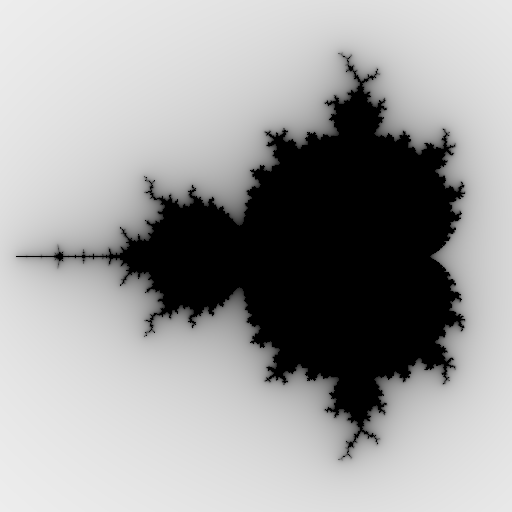

In [30]:
display(image)

### Translating Between Set Elements and Pixels

* Unlike the logarithms before, the math for scaling and translating the image isn’t terribly difficult. However, it adds a bit of code complexity

* You can build a smart pixel data type that’ll encapsulate the conversion between the coordinate systems, account for scaling, and handle the colors

```python
from PIL import Image
from mandelbrot import MandelbrotSet
from viewport import Viewport

mandelbrot_set = MandelbrotSet(max_iterations=20)

image = Image.new(mode='1', size=(512, 512), color=1)  # white background
for pixel in Viewport(image, center=-0.75, width=3.5):
    if complex(pixel) in mandelbrot_set:
        pixel.color = 0

display(image)
```

In [31]:
%%writefile viewport.py

from dataclasses import dataclass
from PIL import Image

@dataclass
class Viewport:
    image: Image.Image
    center: complex
    width: float
        
    @property
    def scale(self):
        return self.width / self.image.width        

    @property
    def height(self):
        return self.scale * self.image.height

    @property
    def offset(self):
        return self.center + complex(-self.width, self.height) / 2

    def __iter__(self):
        for y in range(self.image.height):
            for x in range(self.image.width):
                yield Pixel(self, x, y)

Writing viewport.py


In [32]:
%%writefile -a viewport.py

@dataclass
class Pixel:
    viewport: Viewport
    x: int
    y: int

    @property
    def color(self):
        return self.viewport.image.getpixel((self.x, self.y))

    @color.setter
    def color(self, value):
        self.viewport.image.putpixel((self.x, self.y), value)

    def __complex__(self):
        return complex(self.x, -self.y) * self.viewport.scale + self.viewport.offset

Appending to viewport.py


In [33]:
from PIL import Image
from mandelbrot import MandelbrotSet
from viewport import Viewport

mandelbrot_set = MandelbrotSet(max_iterations=256, escape_radius=1000.0)

image = Image.new(mode='L', size=(512, 512))
for pixel in Viewport(image, center=-0.7435 + 0.1314j, width=0.002):
    c = complex(pixel)
    instability = 1 - mandelbrot_set.stability(c, smooth=True)
    pixel.color = int(instability * 255)

* The viewport spans `0.002` world units and is centered at `-0.7435 + 0.1314j`, $~$which is close to <font color='red'>a Misiurewicz point</font> that produces a beautiful spiral

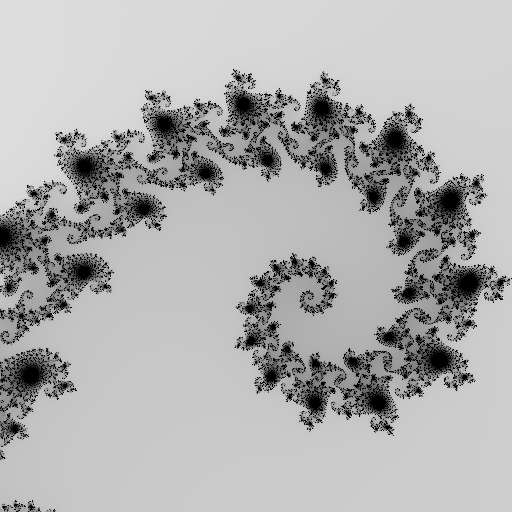

In [34]:
display(image)

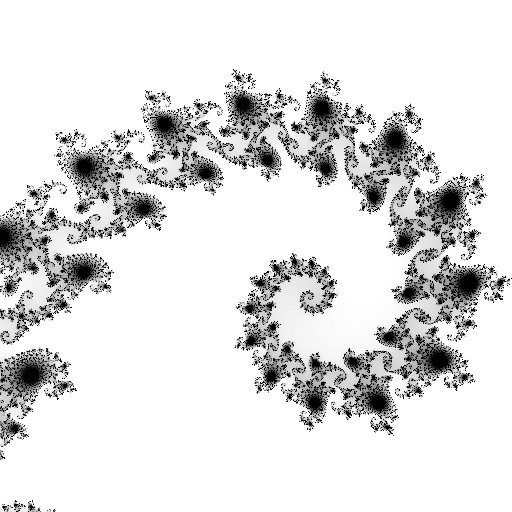

In [35]:
from PIL import ImageEnhance
enhancer = ImageEnhance.Brightness(image)
display(enhancer.enhance(1.4))

* We can find many more unique points producing such spectacular results. $~$Wikipedia hosts an entire [image gallery](https://en.wikipedia.org/wiki/Mandelbrot_set#Image_gallery_of_a_zoom_sequence) of various details of the Mandelbrot set that are worth exploring

In [36]:
mandelbrot_set = MandelbrotSet(max_iterations=256, escape_radius=1000.0)

image = Image.new(mode='L', size=(512, 512))
for pixel in Viewport(image, center=-0.74364990 + 0.13188204j, width=0.00073801):
    c = complex(pixel)
    instability = 1 - mandelbrot_set.stability(c, smooth=True)
    pixel.color = int(instability * 255)

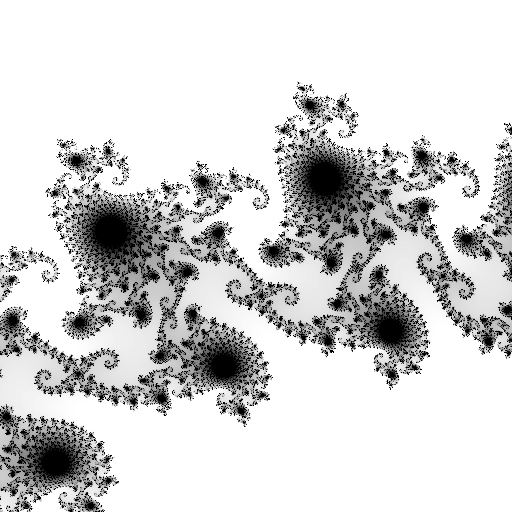

In [37]:
enhancer = ImageEnhance.Brightness(image)
display(enhancer.enhance(1.4))

### Making an Artistic Representation of the Mandelbrot Set

* While there are [many algorithms for plotting the Mandelbrot set in aesthetically pleasing ways](https://en.wikipedia.org/wiki/Plotting_algorithms_for_the_Mandelbrot_set), $~$our imagination is the only limit!

#### Color Palette

* To use more colors, you’ll need to create your image in the RGB mode first, $~$which will allocate 24 bits per pixel:

```python
image = Image.new(mode='RGB', size=(width, height))
```

* From now on, $~$`Pillow` will represent every pixel as a tuple comprised of the red, green, and blue (RGB) color channels

* `Matplotlib` library includes [several colormaps](https://matplotlib.org/3.5.0/tutorials/colors/colormaps.html) with normalized color channels. $~$Some colormaps are fixed lists of colors, $~$while others are able to interpolate values given as a parameter

In [38]:
import matplotlib.cm
colormap = matplotlib.cm.get_cmap('twilight').colors; colormap[:5]

[[0.8857501584075443, 0.8500092494306783, 0.8879736506427196],
 [0.8837852019553906, 0.8507294054031063, 0.8872322209694989],
 [0.8817223105928579, 0.8512759407765347, 0.8863805692551482],
 [0.8795410528270573, 0.8516567540749572, 0.8854143767924102],
 [0.8772488085896548, 0.8518702833887027, 0.8843412038131143]]

* `Pillow` only understands integers in the range of `0` through `255` for the color channels. $~$We need another function that’ll reverse the normalization process to make the Pillow library happy:

In [39]:
def denormalize(colormap):
    return [tuple(int(channel * 255) for channel in color) for color in colormap]

palette = denormalize(colormap); palette[:5] 

[(225, 216, 226),
 (225, 216, 226),
 (224, 217, 226),
 (224, 217, 225),
 (223, 217, 225)]

* The `twilight` colormap is a list of 510 colors. $~$After calling `denormalize()` on it, $~$you’ll get a color palette suitable for your painting function

* If you’d like to test out a couple of different palettes, $~$then it might be convenient to introduce a helper function to avoid retyping the same commands over and over again:

In [40]:
from PIL import Image
from mandelbrot import MandelbrotSet
from viewport import Viewport

def paint(mandelbrot_set, viewport, palette, smooth):
    for pixel in viewport:
        stability = mandelbrot_set.stability(complex(pixel), smooth)
        index = int(min(stability * len(palette), len(palette) - 1))
        pixel.color = palette[index % len(palette)]

* The number of colors in your palette doesn’t necessarily have to equal the maximum number of iterations. $~$After all, it’s unknown how many stability values there’ll be until we run the recursive formula. $~$When we enable smoothing, $~$the number of fractional escape counts can be greater than the number of iterations!

In [41]:
mandelbrot_set = MandelbrotSet(max_iterations=512, escape_radius=1000.0)
image = Image.new(mode='RGB', size=(512, 512))
viewport = Viewport(image, center=-0.7435 + 0.1314j, width=0.002)
paint(mandelbrot_set, viewport, palette, smooth=True)

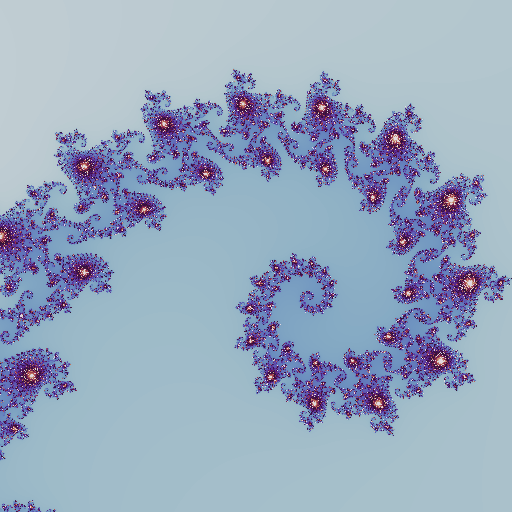

In [42]:
display(image)

* Feel free to try other color palettes included in `Matplotlib` or one of the third-party libraries that they mention in the documentation. $~$Additionally, $~$ `Matplotlib` lets you reverse the color order by appending the `_r` suffix to a colormap’s name

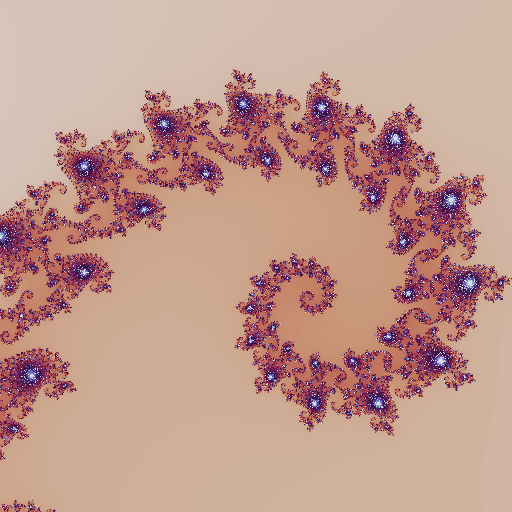

In [43]:
colormap = matplotlib.cm.get_cmap('twilight_r').colors
palette = denormalize(colormap)
paint(mandelbrot_set, viewport, palette, smooth=True)

display(image)

In [44]:
image = Image.new(mode='RGB', size=(768, 768))
viewport = Viewport(image, center=-0.743643135 + 0.131825963j, width= 0.000014628)
colormap = matplotlib.cm.get_cmap("plasma").colors
palette = denormalize(colormap)
paint(mandelbrot_set, viewport, palette, smooth=True)

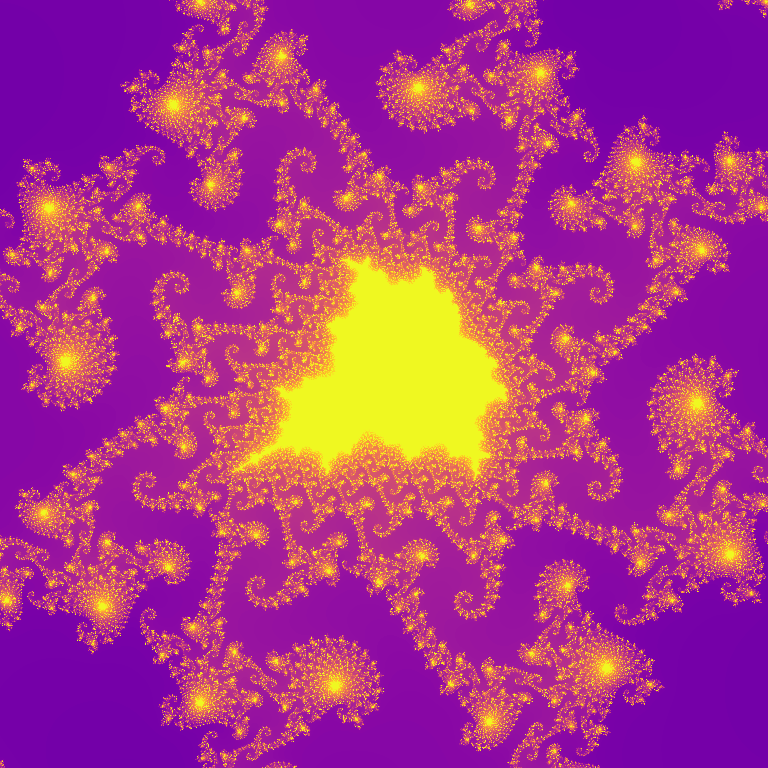

In [45]:
display(image)

* Suppose you wanted to emphasize the fractal’s edge. In such a case, you can divide the fractal into three parts and assign different colors to each:

In [46]:
exterior = [(1, 1, 1)] * 50
interior = [(1, 1, 1)] * 5
gray_area = [(1 - i / 44,) * 3 for i in range(45)]
palette = denormalize(exterior + gray_area + interior)

mandelbrot_set = MandelbrotSet(max_iterations=20, escape_radius=1000.0)
viewport = Viewport(image, center=-0.75, width=2.5)
paint(mandelbrot_set, viewport, palette, smooth=True)

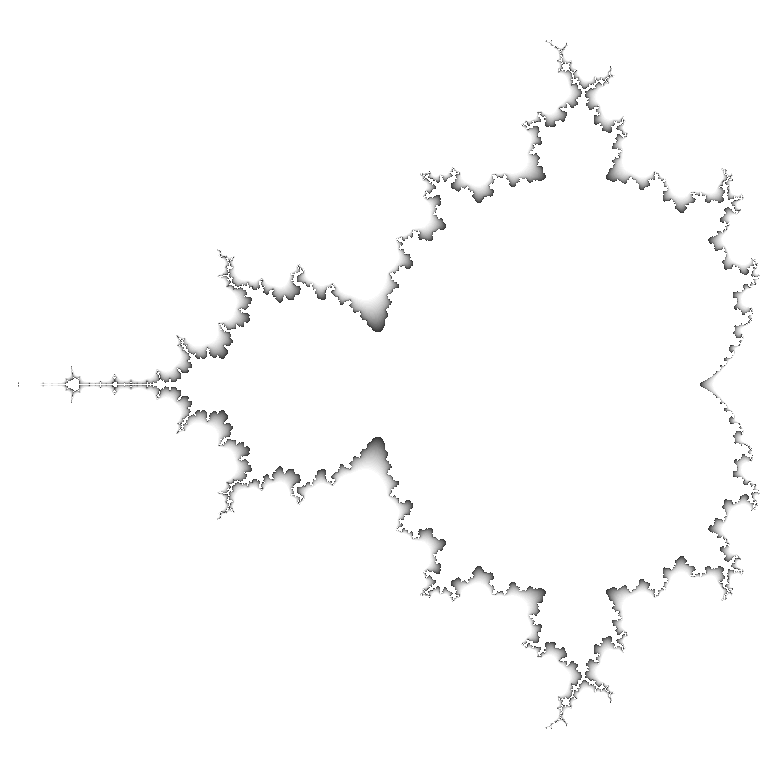

In [47]:
display(image)

#### Color Gradient

In [48]:
import numpy as np
from scipy.interpolate import interp1d

def make_gradient(colors, interpolation='linear'):
    X = [i / (len(colors) - 1) for i in range(len(colors))]
    Y = [[color[i] for color in colors] for i in range(3)]
    channels = [interp1d(X, y, kind=interpolation) for y in Y]
    return lambda x: [np.clip(channel(x), 0, 1) for channel in channels]

In [49]:
black  = (0, 0, 0)
blue   = (0, 0, 1)
maroon = (0.5, 0, 0)
navy   = (0, 0, 0.5)
red    = (1, 0, 0)

colors = [black, navy, blue, maroon, red, black]
gradient = make_gradient(colors, interpolation='cubic')

In [50]:
num_colors = 256
palette = denormalize([gradient(i / num_colors) for i in range(num_colors)])

In [51]:
image = Image.new(mode='RGB', size=(768, 768))
mandelbrot_set = MandelbrotSet(max_iterations=20, escape_radius=1000)
viewport = Viewport(image, center=-0.75, width=2.5)
paint(mandelbrot_set, viewport, palette, smooth=True)

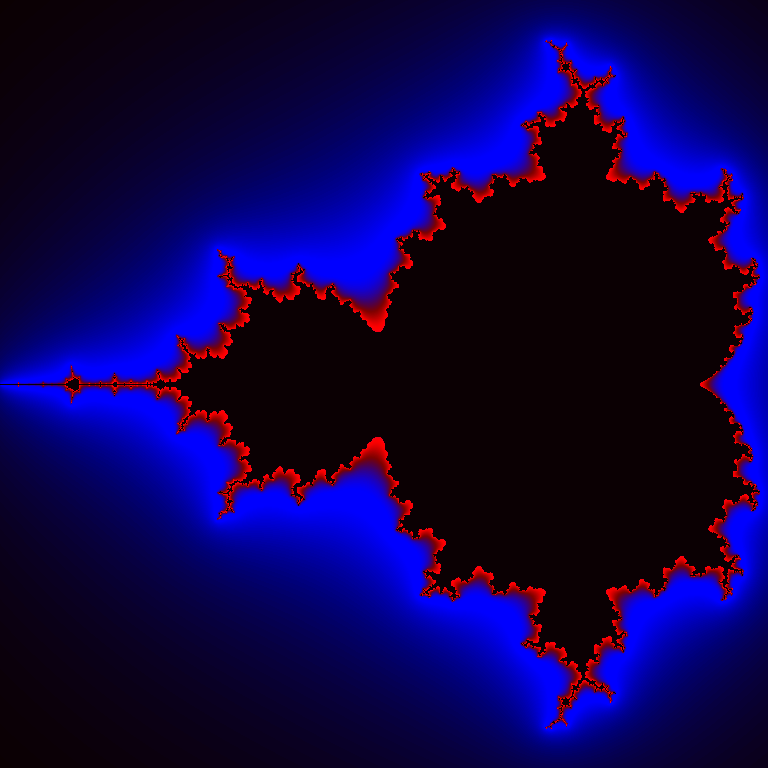

In [52]:
display(image)

#### Color Model

* There are alternative color models that let you express the same concept. $~$One is the Hue, Saturation, Brightness (HSB) color model, also known as Hue, Saturation, Value (HSV)

![Hue Saturation Brightness Cylinder](https://files.realpython.com/media/hsb_256.67b909e67a4e.png)

The three HSB coordinates are:

* **Hue**: The angle measured counterclockwise between `0°` and `360°`
* **Saturation**: The radius of the cylinder between `0%` and `100%`
* **Brightness**: The height of the cylinder between `0%` and `100%`

To use such coordinates in `Pillow`, $~$we must translate them to a tuple of RGB values in the familiar range of `0` to `255`:

---

In [53]:
from PIL.ImageColor import getrgb

def hsb(hue_degrees: int, saturation: float, brightness: float):
    return getrgb( 
        f"hsv({hue_degrees % 360},"
        f"{saturation * 100}%,"
        f"{brightness * 100}%)"
    )

image = Image.new(mode='RGB', size=(768, 768))
mandelbrot_set = MandelbrotSet(max_iterations=20, escape_radius=1000.0)

for pixel in Viewport(image, center=-0.75, width=2.5):
    stability = mandelbrot_set.stability(complex(pixel), smooth=True)
    pixel.color = (0, 0, 0) if stability == 1 else hsb(
        hue_degrees=int((1 - stability) * 360),
        saturation=1 - stability,
        brightness=1,
    )

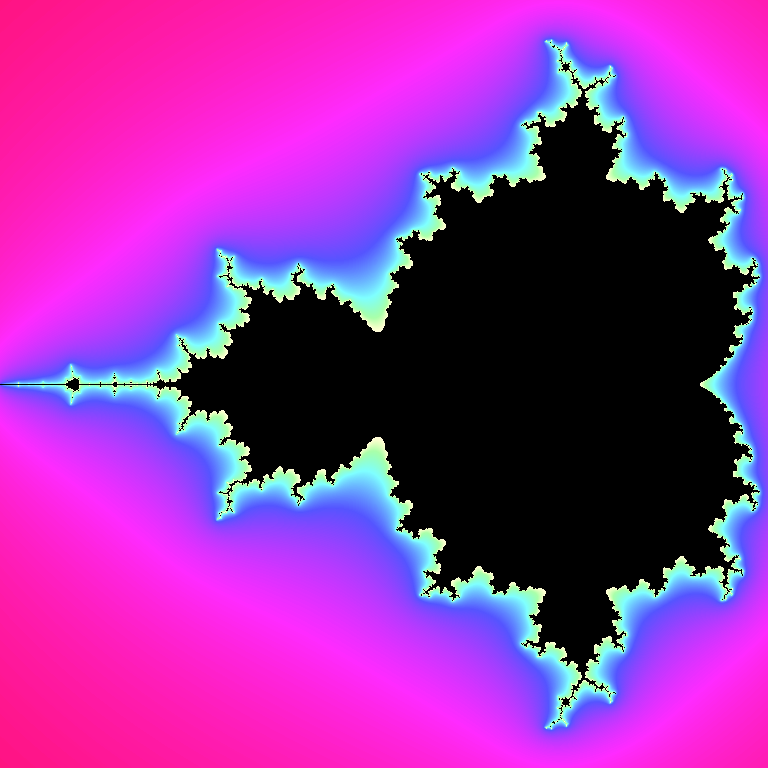

In [54]:
display(image)

## Conclusions

**In this tutorial, $~$we learned how to:**

* Apply complex numbers to a practical problem
* Find members of the Mandelbrot set
* Draw these sets as fractals using `Matplotlib` and `Pillow`
* Make a colorful artistic representation of the fractals

Now we know how to use Python to plot and draw the famous fractal discovered by Benoît Mandelbrot

In [55]:
import os

os.remove('mandelbrot.py')
os.remove('viewport.py')